In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Read the csv from file to variable df

#df = pd.read_csv('finalData.csv')
df = pd.read_csv('finalData.csv')

Text(0, 0.5, 'Frequency')

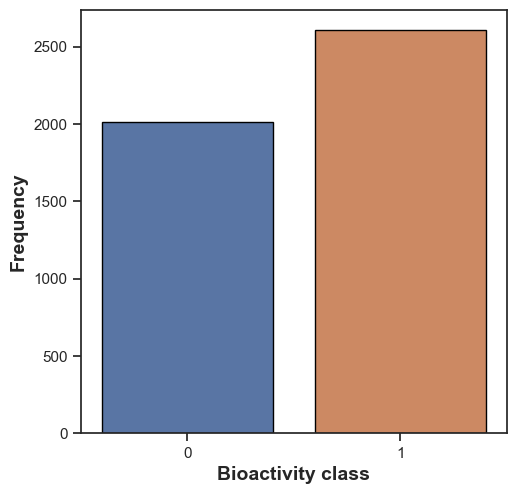

In [3]:
sns.set(style='ticks')
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

In [4]:
X = df['canonical_smiles']
y = df['class']

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [6]:
# Tokenize the SMILES strings
tokenizer = Tokenizer(char_level=True, lower=False)
tokenizer.fit_on_texts(X)
X_encoded = tokenizer.texts_to_sequences(X)

In [7]:
# After fitting tokenizer during training
import pickle
with open('tokenizer2.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Pad sequences to have the same length
#X_padded = pad_sequences(X_encoded)
X_padded = pad_sequences(X_encoded)

In [11]:
print(X_padded.shape)

(5657, 181)


In [12]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [13]:
#vocab_size = len(token_to_index) + 1 
vocab_size = len(tokenizer.word_index) + 1

In [14]:
from tensorflow.keras.layers import Dropout, ActivityRegularization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

# Model Architecture
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=X_padded.shape[1]))
model.add(BatchNormalization())


model.add(LSTM(32))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Example dropout layer

# Fully connected layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.02)))  # Example L2 regularization
model.add(Dropout(0.5))  # Additional dropout layer

# Output layer
model.add(Dense(1, activation='sigmoid'))

In [15]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 181, 64)           2560      
                                                                 
 batch_normalization (Batch  (None, 181, 64)           256       
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC


# Model Compilation
optimizer = Adam(learning_rate=0.0005, clipvalue=1.0)  # Adjust clipnorm as needed
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', AUC(name='auc')])

In [17]:
from sklearn.metrics import log_loss, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Lists to store training and validation loss values
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Training loop
epochs = 30
for epoch in range(epochs):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=32, verbose=1, callbacks=[early_stopping, reduce_lr])

    # Predict on training and test set
    y_train_pred = model.predict(X_train, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    # Compute log loss
    train_loss = log_loss(y_train, y_train_pred)
    val_loss = log_loss(y_test, y_test_pred)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    
    # Convert probabilities to class labels
    y_train_classes = (y_train_pred > 0.5).astype(int)
    y_test_classes = (y_test_pred > 0.5).astype(int)

    # Compute accuracy
    train_acc = accuracy_score(y_train, y_train_classes)
    val_acc = accuracy_score(y_test, y_test_classes)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    
    

    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    



142/142 [==============================] - 9s 44ms/step - loss: 1.6181 - accuracy: 0.5284 - auc: 0.5228 - val_loss: 1.5012 - val_accuracy: 0.5654 - val_auc: 0.5108 - lr: 1.0000e-04
Epoch 1/50, Training Loss: 0.6882, Val Loss: 0.6882
142/142 [==============================] - 6s 41ms/step - loss: 1.4959 - accuracy: 0.5556 - auc: 0.5681 - val_loss: 1.4351 - val_accuracy: 0.5495 - val_auc: 0.5466 - lr: 1.0000e-04
Epoch 2/50, Training Loss: 0.6859, Val Loss: 0.6861
142/142 [==============================] - 5s 38ms/step - loss: 1.4021 - accuracy: 0.5856 - auc: 0.6084 - val_loss: 1.3708 - val_accuracy: 0.5724 - val_auc: 0.5712 - lr: 1.0000e-04
Epoch 3/50, Training Loss: 0.6794, Val Loss: 0.6808
142/142 [==============================] - 6s 40ms/step - loss: 1.3368 - accuracy: 0.5903 - auc: 0.6229 - val_loss: 1.2954 - val_accuracy: 0.5998 - val_auc: 0.6373 - lr: 1.0000e-04
Epoch 4/50, Training Loss: 0.6572, Val Loss: 0.6597
142/142 [==============================] - 6s 41ms/step - loss: 1.

In [19]:
# Make predictions on the test set
y_pred = model.predict(X_test)

36/36 [==============================] - 0s 11ms/step


In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Use the predict method to get probabilities
y_pred_prob = model.predict(X_test)

# Threshold probabilities to get predicted classes (assuming binary classification)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')


36/36 [==============================] - 0s 13ms/step
Test Accuracy: 0.8048


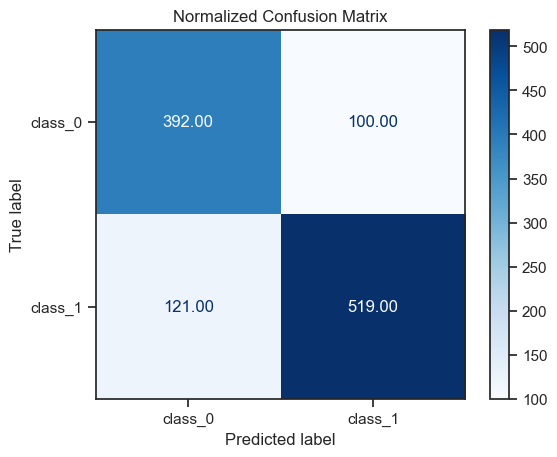

In [21]:
# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class_0', 'class_1'])
disp.plot(cmap=plt.cm.Blues, values_format='.2f')

# Add a title
plt.title('Normalized Confusion Matrix')

plt.show()

In [22]:
# Generate a classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78       492
           1       0.84      0.81      0.82       640

    accuracy                           0.80      1132
   macro avg       0.80      0.80      0.80      1132
weighted avg       0.81      0.80      0.81      1132



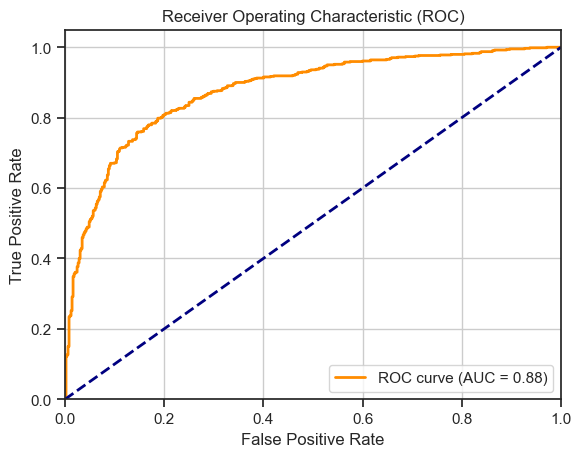

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# True binary labels
y_true = y_test

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


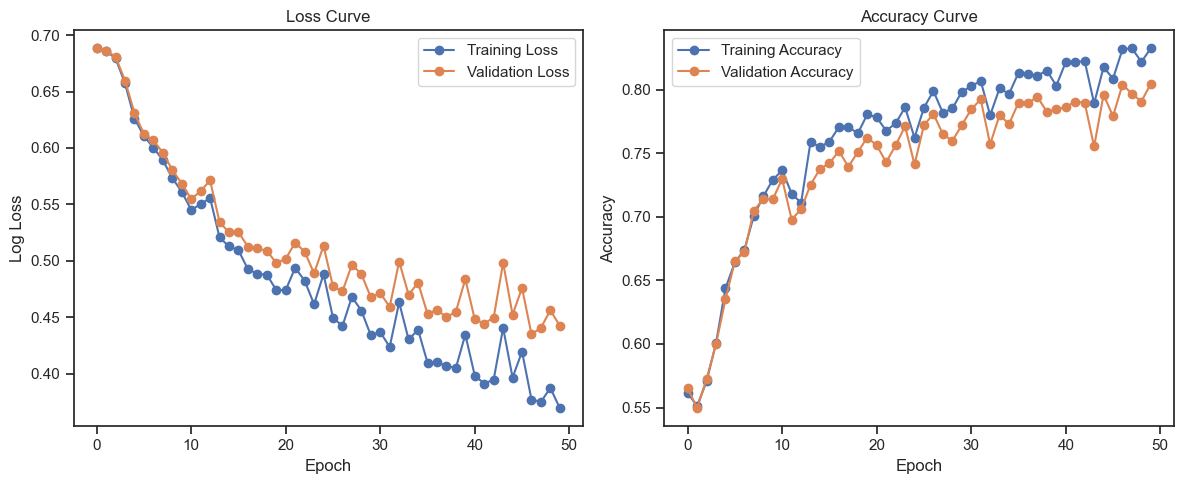

In [25]:
# Plotting curves
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
model.save('lstm_model.h3')
model.save('saved_model/my_model3')

INFO:tensorflow:Assets written to: lstm_model.h7\assets


INFO:tensorflow:Assets written to: lstm_model.h7\assets


INFO:tensorflow:Assets written to: saved_model/my_model7\assets


INFO:tensorflow:Assets written to: saved_model/my_model7\assets
